## 0. Import Pytorch and setting up device-agnostic code

In [1]:
import torch
from numpy import number
from torch import nn
torch.__version__

'2.1.0+cu118'

In [2]:
# Setup device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 1. Get data

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path('./data')
img_path = data_path / 'pizza_steak_sushi'

if img_path.is_dir():
    print(f'{img_path} directory exists')
else:
    print(f'Did not find {img_path} directory, creating one...')
    img_path.mkdir(parents=True, exist_ok=True)

    # Download pizza steak sushi data
    with open(data_path/'pizza_steak_sushi.zip', 'wb') as file:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        file.write(request.content)

    # Unzip data
    with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip') as file:
        print("Unzipping pizza, steak, sushi data...")
        file.extractall(img_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


## 2. Become one with the data (data preparation)

In [4]:
import os
def walk_through_dir(dir_path):
    for dir_path, dir_names, filenames in os.walk(dir_path):
        print(f"There are {len(dir_names)} directories and {len(filenames)} images in '{dir_path}'.")
walk_through_dir('./data/pizza_steak_sushi')

There are 2 directories and 0 images in './data/pizza_steak_sushi'.
There are 3 directories and 0 images in './data/pizza_steak_sushi/train'.
There are 0 directories and 78 images in './data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in './data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in './data/pizza_steak_sushi/train/sushi'.
There are 3 directories and 0 images in './data/pizza_steak_sushi/test'.
There are 0 directories and 25 images in './data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in './data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in './data/pizza_steak_sushi/test/sushi'.


In [5]:
# Set up train and testing paths
train_dir = img_path / 'train'
test_dir = img_path / 'test'

### 2.1 Visualize an image

In [6]:
import random
from PIL import Image

Random image path: data/pizza_steak_sushi/train/pizza/2811032.jpg
Image class: pizza
Image height: 512
Image width: 512


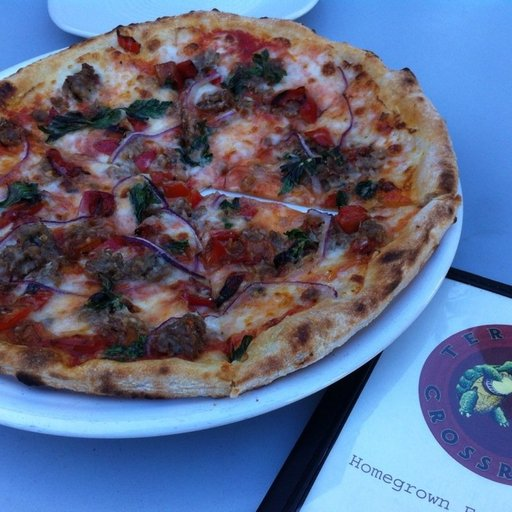

In [7]:
random.seed(42)
img_path_list = list(img_path.glob('*/*/*.jpg'))
rand_img_path = random.choice(img_path_list)
img_class = rand_img_path.parent.stem
img = Image.open(rand_img_path)

# 5. Print metadata
print(f"Random image path: {rand_img_path}")
print(f"Image class: {img_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

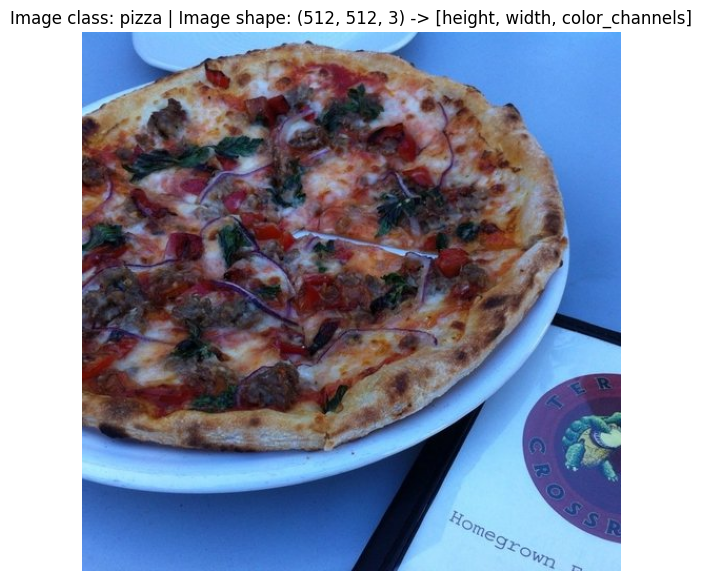

In [8]:
# The same with plt
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {img_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

## 3. Transforming data

In [9]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transform`

In [10]:
#Write transform for image
data_transform = transforms.Compose([
    #Resize img to 64x64
    transforms.Resize(size=(64,64)),
    # Flip img randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.6),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

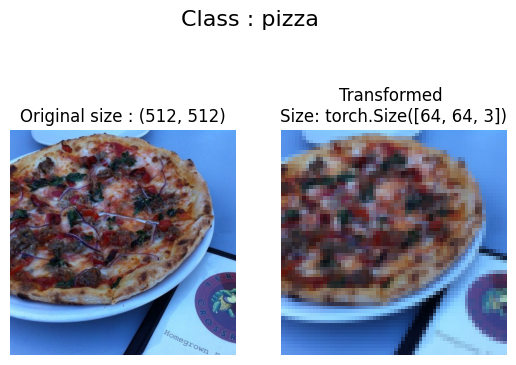

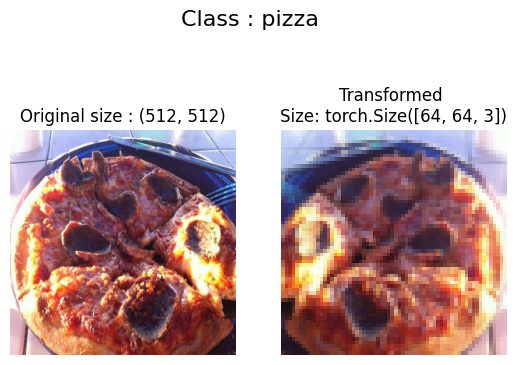

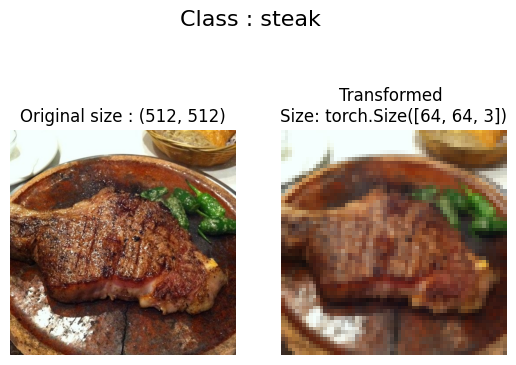

In [11]:
def plot_transformed_img(img_paths, transform, n=3, seed=42):
    random.seed(seed)

    rand_img_path = random.sample(img_paths, k=n)
    for img_path in rand_img_path:
        with Image.open(img_path) as img:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(img)
            ax[0].set_title(f'Original size : {img.size}')
            ax[0].axis('off')

            # Transform and plot img
            # Pytorch default is [C, H, W] but matplotlib default is [H,W, C]
            transformed_img = transform(img).permute([1, 2, 0])
            ax[1].imshow(transformed_img)
            ax[1].set_title(f"Transformed \nSize: {transformed_img.shape}")
            ax[1].axis("off")

            fig.suptitle(f'Class : {img_path.parent.stem}', fontsize='16')
plot_transformed_img(img_path_list, data_transform)

## 4. Option 1: Loading Image Data Using `ImageLoader`

In [12]:
# Using `ImageLoader` to create data
train_data = datasets.ImageFolder(root=train_dir, transform=data_transform, target_transform=None)
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)
print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.6)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.6)
               ToTensor()
           )


In [13]:
# Get class name as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [14]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [15]:
# Check the lengths
len(train_data), len(test_data)

(225, 75)

In [16]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


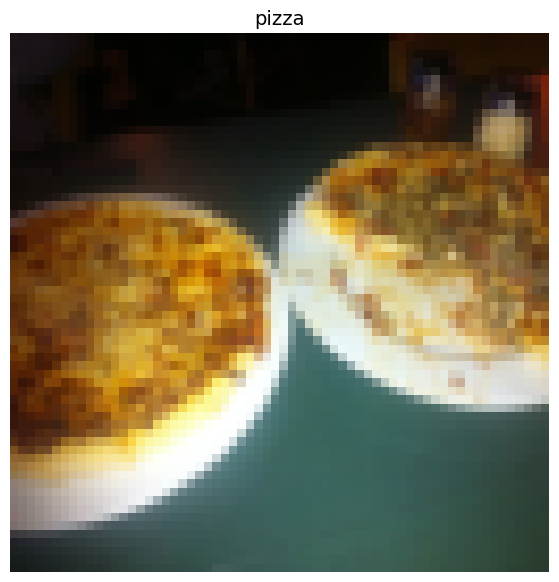

In [17]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

### 4.1 Turn loaded images into `DataLoader`'s

In [18]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    dataset=train_data,
    num_workers=1,
    batch_size=1,
    shuffle=True
)
test_dataloader = DataLoader(
    dataset=train_data,
    num_workers=1,
    batch_size=1,
)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7ca8277df370>,
 <torch.utils.data.dataloader.DataLoader at 0x7ca8277df940>)

In [19]:
# Try it out and check the shape
img, label = next(iter(train_dataloader))
# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 5.1 Option 2: Load images data with a Custom `Dataset`

In [20]:
import os
import pathlib

from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [21]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

In [22]:
target_directory = train_dir
print(f'Target directory: {target_directory}')

class_names_found = sorted([entry.name for entry in list(os.scandir(img_path / 'train'))])
class_names_found

Target directory: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [23]:
def find_classes(dir_name:str) -> Tuple[List[str], Dict[str, int]]:
    classes = sorted(entry.name for entry in os.scandir(dir_name) if entry.is_dir())

    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {dir_name}")

    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

    return classes, class_to_idx

In [24]:
find_classes(dir_name=target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom Dataset to replicate ImageFolder

In [25]:
class ImageFolderCustom(Dataset):
    def __init__(self, target_dir, transform=None):
        self.paths = list(pathlib.Path(target_dir).glob('*/*.jpg'))

        self.transforms = transform

        self.classes, self.class_to_idx = find_classes(target_dir)

    def load_img(self, index: int)->Image.Image:
        """Opens an image via a path and returns it."""
        img_path = self.paths[index]
        return Image.open(img_path)

    def __len__(self)->int:

        return len(self.paths)

    def __getitem__(self, index:int)-> Tuple[torch.Tensor, int]:
        img = self.load_img(index)
        class_name = self.paths[index].parent.stem
        class_idx = self.class_to_idx[class_name]

        if self.transforms is not None:
            return self.transforms(img), class_idx
        else:
            return img, class_idx


In [26]:
# Augment train data
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(0.6),
    transforms.ToTensor()
]),
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [27]:
train_data_custom = ImageFolderCustom(target_dir=train_dir, transform=test_transform)
test_data_custom = ImageFolderCustom(target_dir=test_dir, transform=test_transform)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7ca82bce3460>,
 <__main__.ImageFolderCustom at 0x7ca82bce35e0>)

In [28]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [29]:
# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


In [30]:
def display_rand_img(
        dataset: Dataset,
        classes : List[str] = None,
        n: int = 10,
        display_shape: bool = True,
        seed : int = 42):
    if n > 10:
        n = 10
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display")

    random.seed(seed)
    rand_samples_idx = random.sample(range(len(dataset)), k=n)

    plt.figure(figsize=(15, 8))

    for i, sample_idx in enumerate(rand_samples_idx):
        img, label = dataset[sample_idx][0], dataset[sample_idx][1]
        img = img.permute([1, 2, 0])

        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis('off')
        title = ''
        if classes:
            title = f"class: {classes[label]}"
            if display_shape:
                title = title + f"\nshape: {img.shape}"
        plt.title(title)



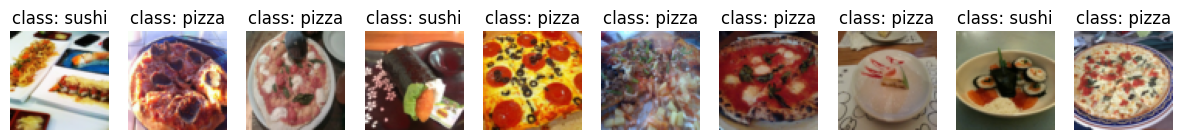

In [31]:
display_rand_img(dataset=train_data, display_shape=False, n=10, classes=class_names, seed=42)


## 5.4 Turn custom loaded images into DataLoader

In [32]:
# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(dataset=train_data_custom, # use custom created train Dataset
                                     batch_size=1, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

test_dataloader_custom = DataLoader(dataset=test_data_custom, # use custom created test Dataset
                                    batch_size=1,
                                    num_workers=0,
                                    shuffle=False) # don't usually need to shuffle testing data

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7ca8278f0f10>,
 <torch.utils.data.dataloader.DataLoader at 0x7ca8277fffd0>)

In [33]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 6. Other of forms of transforms(data augmentation)

In [34]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31
                                  ), # how intense
    transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
])

# Don't need to perform augmentation on the test data
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

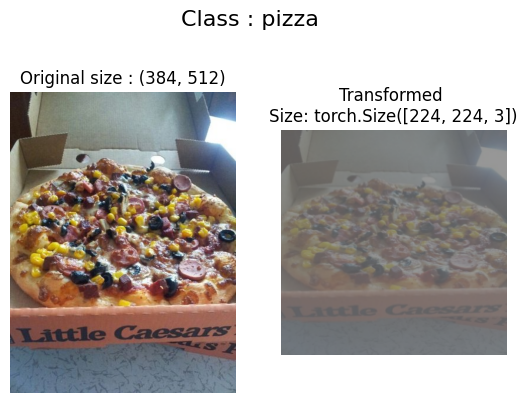

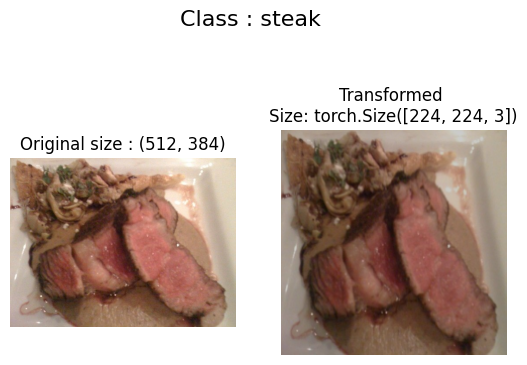

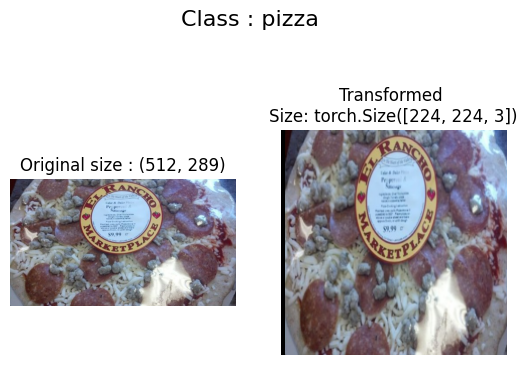

In [35]:
# Get all image paths
image_path_list = list(img_path.glob("*/*/*.jpg"))

# Plot random images
plot_transformed_img(
    img_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)

## 7. Model 0: TinyVGG without data augmentation

### 7.1 Creating transform and loading data for model 0

In [36]:
simple_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [37]:
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform )
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform )

BATCH_SIZE = 32
NUM_WORKS = os.cpu_count()

train_dataloader_simple = DataLoader(dataset=train_data_simple, batch_size=BATCH_SIZE, num_workers=NUM_WORKS)
test_dataloader_simple = DataLoader(dataset=test_data_simple, batch_size=BATCH_SIZE, num_workers=NUM_WORKS)

### 7.2 Create TinyVGG model class

In [38]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, kernel_size=3,
                    padding=1,
                    stride=1,
                    out_channels=hidden_units
                      ),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, kernel_size=3,
                    padding=1,
                    stride=1,
                    out_channels=hidden_units
                      ),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16, out_features=output_shape)
        )

    def forward(self, x:torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)

        return self.classifier(x)

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on simple image (to test to model)

In [39]:
# 1. Get a batch of images and labels from DataLoader
img_batch, label_batch = next(iter(train_dataloader_simple))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]

# 3. Perform a forward pass on a simple image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))

# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Output logits:
tensor([[0.0602, 0.0636, 0.0365]], device='cuda:0')

Output prediction probabilities:
tensor([[0.3356, 0.3367, 0.3277]], device='cuda:0')

Output prediction label:
tensor([1], device='cuda:0')

Actual label:
0


### 7.4 Use **torchinfo** to get an idea of the shapes going through our model

In [40]:
try:
  import torchinfo
except ModuleNotFoundError:
  !pip install torchinfo
  import torchinfo

In [41]:
from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

### 7.5 Create train and test loop functions

In [42]:
def train_step(model: nn.Module,
               dataloader: DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer
               ):
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss = train_acc = 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      train_pred = model(X)

      # 2. Calculate and accumulate loss
      loss = loss_fn(train_pred, y)
      train_loss += loss

      # 3. Optimizer zeros grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumate accuracy metric arcoss batches
      train_pred = torch.argmax(torch.softmax(train_pred, dim=1),dim=1)

      train_acc += (train_pred == y).sum().item() / len(y)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss, train_acc

In [43]:
def test_step(
    model: nn.Module,
    dataloader: DataLoader,
    loss_fn: nn.Module,):
  # Put model in eval mode
  model.eval()

  # Set up loss and accuracy
  test_loss = test_acc = 0

  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):

      # Send data to the target device
      X, y = X.to(device), y.to(device)

      # 1.Test forward
      test_pred_logistic = model(X)

      # 2. Calculate and accumate loss
      loss = loss_fn(test_pred_logistic, y)
      test_loss += loss

      # Calculate and accumate accuracy
      test_pred = torch.argmax(torch .softmax(test_pred_logistic, dim=1), dim=1)
      test_acc += (test_pred == y).sum().item() / len(y)

    # Adjust metrics to get average loss and accuracy per batch
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

  return test_loss, test_acc


### 7.6 Creating a **train()** function to combine **train_step()** and **test_step()**

In [44]:
from tqdm.auto import tqdm

# 1. Take in various parameter required for training and test steps
def train_model(model: nn.Module,
                train_dataloader: DataLoader,
                test_dataloader: DataLoader,
                loss_fn: nn.Module,
                optimizer: torch.optim.Optimizer,
                epochs :int = 5):
  # 2. Create empty results dictionary
  results = {
      'train_loss' : [],
      'train_acc' : [],
      'test_acc' : [],
      'test_loss' : []
  }
  # 3. Loop through training and testing steps for a number of epoches
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model_0,
                                       dataloader=train_dataloader_simple,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)

    test_loss, test_acc = test_step(model=model_0,
                                    dataloader=test_dataloader_simple,
                                    loss_fn = loss_fn)
     # 4. Print out what's happening
    print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )
    # 5. Update results dictionary
    results['train_loss'].append(train_loss.detach().item())
    results['train_acc'].append(train_acc)
    results['test_loss'].append(test_loss.detach().item())
    results['test_acc'].append(test_acc)

  return results

### 7.7 Train and Evalluate Model V0

In [46]:
# Set random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

from timeit import default_timer

start_time_v0 = default_timer()

result_model_v0 = train_model(model=model_0,
                              train_dataloader=train_dataloader_simple,
                              test_dataloader=test_dataloader_simple,
                              loss_fn = loss_fn,
                              optimizer=optimizer,
                              epochs=epochs)
end_time_v0 = default_timer()
print(f"Total training time: {end_time_v0-start_time_v0:.3f} seconds")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2886 | train_acc: 0.2773 | test_loss: 1.2000 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.1058 | train_acc: 0.3047 | test_loss: 1.1287 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0914 | train_acc: 0.3047 | test_loss: 1.0947 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.0895 | train_acc: 0.5273 | test_loss: 1.0764 | test_acc: 0.5417
Epoch: 5 | train_loss: 1.0919 | train_acc: 0.4023 | test_loss: 1.0662 | test_acc: 0.5417
Epoch: 6 | train_loss: 1.0913 | train_acc: 0.4023 | test_loss: 1.0592 | test_acc: 0.5417
Epoch: 7 | train_loss: 1.0920 | train_acc: 0.4023 | test_loss: 1.0546 | test_acc: 0.5417
Epoch: 8 | train_loss: 1.0919 | train_acc: 0.4023 | test_loss: 1.0515 | test_acc: 0.5417
Epoch: 9 | train_loss: 1.0894 | train_acc: 0.4023 | test_loss: 1.0487 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.0853 | train_acc: 0.4023 | test_loss: 1.0453 | test_acc: 0.5417
Epoch: 11 | train_loss: 1.0746 | train_acc: 0.4023 | test_loss: 1.0403 | test_acc: 0.5417
Epoch: 12 | train_l

In [47]:
result_model_v0

{'train_loss': [1.2886080741882324,
  1.1057586669921875,
  1.0914170742034912,
  1.0895315408706665,
  1.091897964477539,
  1.0913317203521729,
  1.0919629335403442,
  1.091911792755127,
  1.089428424835205,
  1.08526611328125,
  1.0746238231658936,
  1.0621193647384644,
  1.0388091802597046,
  1.0064918994903564,
  0.9674434661865234,
  0.9383985996246338,
  0.9037140607833862,
  0.8768790364265442,
  0.8527764678001404,
  0.8307610750198364,
  0.8118462562561035,
  0.7994774580001831,
  0.7816802859306335,
  0.7712262272834778,
  0.7621729373931885,
  0.751850962638855,
  0.7416684627532959,
  0.7304939031600952,
  0.7224919199943542,
  0.714716911315918,
  0.7063090801239014,
  0.6986441016197205,
  0.6905396580696106,
  0.6829213500022888,
  0.6748764514923096,
  0.666618824005127,
  0.658883810043335,
  0.6511930227279663,
  0.642565906047821,
  0.6344231367111206,
  0.6251497864723206,
  0.6170864701271057,
  0.6070395112037659,
  0.5977067947387695,
  0.5873162150382996,
  0.57

In [48]:
# Check the model_0_results keys
result_model_v0.keys()

dict_keys(['train_loss', 'train_acc', 'test_acc', 'test_loss'])

In [49]:
def plot_loss_curves(results : Dict[str, List[float]]):
  train_loss = results['train_loss']
  test_loss = results['test_loss']

  train_acc = results['train_acc']
  test_acc = results['test_acc']

  epochs = range(len(train_loss))

  plt.figure(figsize=(15, 5))
  # Plot loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, train_loss, label='Training')
  plt.plot(epochs, test_loss, label='Testing')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, train_acc, label='Training')
  plt.plot(epochs, test_acc, label='Testing')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()


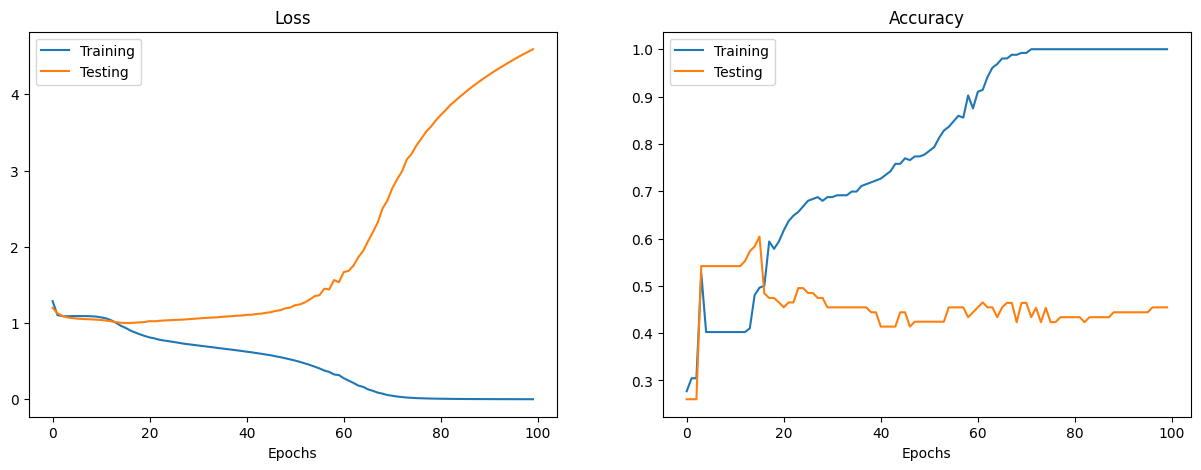

In [50]:
plot_loss_curves(result_model_v0)

## 8.Model 1: TinyVGG with Data Agumetation

### 9.1 Create transform with data agumetation

In [ ]:
# Create training transform with T